In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})

df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')

df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)
print(df.columns)

(113472, 4)
Index(['Power', 'POA', 'Tmod', 'Temp'], dtype='object')


In [3]:
## Define the morning hour range
#start_hour = 6
#end_hour = 21
## Filter rows based on morning hour range
#df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
#print(df.shape)

In [4]:
#df = df[df['POA']>0]
#df = df[df['Power']>0]
#print(df.shape)

In [5]:
# Solar panel = JKM345M-72-V x 5742 panels
POA_std = 1000
Capacity = 5742*345/1000000
T_std = 25 
#T_std = df['Tmod'].mean()
alpha = -0.004

'''
start_date = '2023-11-20'
end_date = '2023-11-22'

test = (df['Power'][start_date:end_date])/(Capacity*(1 + alpha*(df['Tmod'][start_date:end_date] - T_std))*df['POA'][start_date:end_date]/POA_std)
print(test)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
temp = test.dropna()
P_constant = np.mean(temp[temp>0])
P_constant = np.mean(temp)
print(P_constant)
'''

df['shifted_Power'] = df['Power'] 
df.loc['2023-04-02':'2023-09-30', 'shifted_Power'] = df.loc['2023-04-02':'2023-09-30', 'Power'].shift(periods=60, freq='T')


P_constant = 1.0
df['Power_calculated'] = P_constant*Capacity*(1 + alpha*(df['Tmod'] - T_std))*df['POA']/POA_std
df['Power_error'] = df['Power_calculated'] - df['shifted_Power']


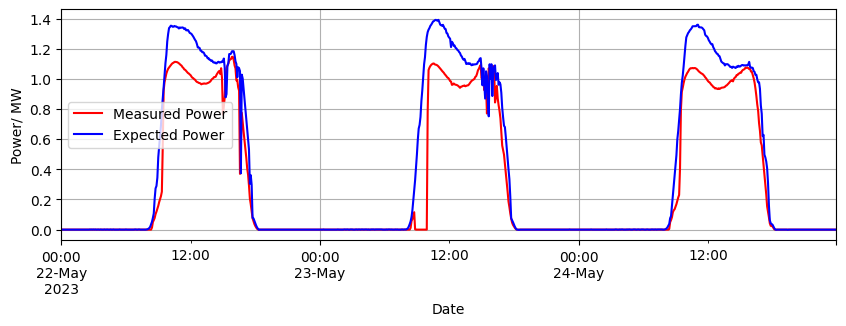

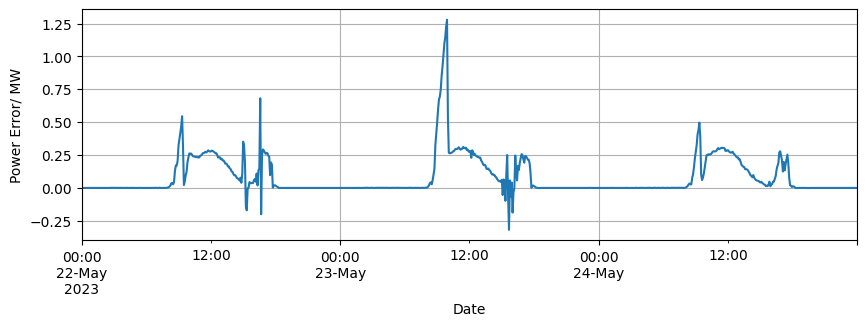

In [6]:
# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-24'

#start_date = df.index.min()
#end_date = df.index.max()


# Slice the DataFrame based on the specified period
df['shifted_Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Measured Power')
df['Power_calculated'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'],label='Expected Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


ax = df['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3))
plt.ylabel('Power Error/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [7]:
df.shape

(113472, 7)

In [8]:
df.describe()

,Power,POA,Tmod,Temp,shifted_Power,Power_calculated,Power_error
count,113472.000000,113472.000000,113472.000000,113472.000000,113460.000000,113472.000000,113460.000000
mean,0.296731,233.306539,17.490338,15.354025,0.296762,0.436020,0.139304
std,0.513418,374.776575,16.046519,33.016471,0.513436,0.691944,0.641691
min,0.000000,-1.139593,-6.118014,0.000000,0.000000,-0.002292,-1.700100
25%,0.000000,-0.054264,4.311919,7.100000,0.000000,-0.000116,-0.001209
50%,0.000061,0.000000,13.214670,13.800000,0.000061,0.000000,-0.000113
75%,0.408688,403.147500,28.085210,20.400000,0.408852,0.785646,0.141633
max,1.700452,1502.591000,68.853870,655.260000,1.700452,2.816438,2.816438


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

# Define the period you want to plot
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date][['Power','Power_error']].resample('5min').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
print(temp.shape)
temp_cleaned = temp.dropna()
print(temp_cleaned.shape)
data = temp_cleaned.values
print(temp_cleaned.index)


full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='5min')
temp_cleaned_reindexed = temp_cleaned.reindex(full_date_range)

df_ffill = temp_cleaned_reindexed.ffill()

if df_ffill.isnull().values.any():
    df_filled = df_ffill.bfill()
else:
    df_filled = df_ffill

2024-08-02 13:13:35.308627: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 13:13:35.788147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 13:13:39.029950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True
False
(113472, 2)
(113460, 2)
DatetimeIndex(['2023-02-01 00:00:00', '2023-02-01 00:05:00',
               '2023-02-01 00:10:00', '2023-02-01 00:15:00',
               '2023-02-01 00:20:00', '2023-02-01 00:25:00',
               '2023-02-01 00:30:00', '2023-02-01 00:35:00',
               '2023-02-01 00:40:00', '2023-02-01 00:45:00',
               ...
               '2024-02-29 23:10:00', '2024-02-29 23:15:00',
               '2024-02-29 23:20:00', '2024-02-29 23:25:00',
               '2024-02-29 23:30:00', '2024-02-29 23:35:00',
               '2024-02-29 23:40:00', '2024-02-29 23:45:00',
               '2024-02-29 23:50:00', '2024-02-29 23:55:00'],
              dtype='datetime64[ns]', name='time', length=113460, freq=None)


In [10]:
# Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

In [63]:
# Create sequences/windows

def create_sequences(data, timesteps, overlap):
    sequences = []
    step_size = timesteps - overlap
    num_sequences = (len(data) - timesteps) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        end = start + timesteps
        if end <= len(data):  # Ensure we don't exceed data length
            sequences.append(data[start:end])
    
    return np.array(sequences)


# Train-test split
#X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Define the split ratio
train_ratio = 1.0
test_ratio = 0.0
num_train_samples = int(train_ratio * len(data_normalized))

# Split the data
train_data = data_normalized[:num_train_samples]
test_data = data_normalized[num_train_samples:]

train_data_date = temp_cleaned.index[:num_train_samples]
test_data_date = temp_cleaned.index[num_train_samples:]


timesteps = 24  # Example sequence leng|th
overlap = 8
train_sequences = create_sequences(train_data, timesteps,overlap)
test_sequences = create_sequences(test_data, timesteps,overlap)

print("Shape of the train sequences array:", train_sequences.shape)
print("Shape of the test sequences array:", test_sequences.shape)

Shape of the train sequences array: (7090, 24, 2)
Shape of the test sequences array: (0,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   
latent_dim = 5
dropout_rate = 0.2



# Encoder
inputs = Input(shape=(timesteps, input_dim),name='encoder_input')
h = LSTM(64, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate,name='encoder_lstm1')(inputs)
h = LSTM(32,name='encoder_lstm2')(h)
z_mean = Dense(latent_dim,name='z_mean')(h)
z_log_var = Dense(latent_dim,name='z_log_var')(h)
z = Lambda(sampling, output_shape=(latent_dim,),name='z')([z_mean, z_log_var])

# Decoder
#decoder_h1 = Dense(64)
decoder_repeat = RepeatVector(timesteps,name='decoder_repeat')
decoder_h2 = LSTM(32, return_sequences=True,name='decoder_lstm1')
decoder_lstm = LSTM(64, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate,name='decoder_lstm2')
decoder_output = TimeDistributed(Dense(input_dim),name='decoder_output')

#z = decoder_h1(z)
h_decoded = decoder_repeat(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)
    
# VAE model
vae = Model(inputs, x_decoded_mean, name='vae')
encoder = Model(inputs, z_mean, name='encoder')


# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(x_decoded_mean))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.15*kl_loss)
vae.add_loss(vae_loss)

batch_size = 32

checkpoint_callback = ModelCheckpoint(
    filepath='/home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data_lstm/model_checkpoint_{epoch:02d}.h5',
    save_freq=5 * len(train_sequences) // batch_size,  # Change this to 'batch' to save after every batch
    verbose=1  # Set to 1 for verbose logging, 0 for silent
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=10, # Stop after 10 epochs of no improvement
    verbose=1
)

# Compile model
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)
vae.summary()


# Train the VAE with early stopping
#history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, callbacks=[checkpoint_callback])
history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping_callback, checkpoint_callback])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [12]:
vae = tf.keras.models.load_model('/home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data_lstm/model_checkpoint_50.h5')

2024-08-02 13:14:04.877312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


222/222 [==============================] - 5s 13ms/step


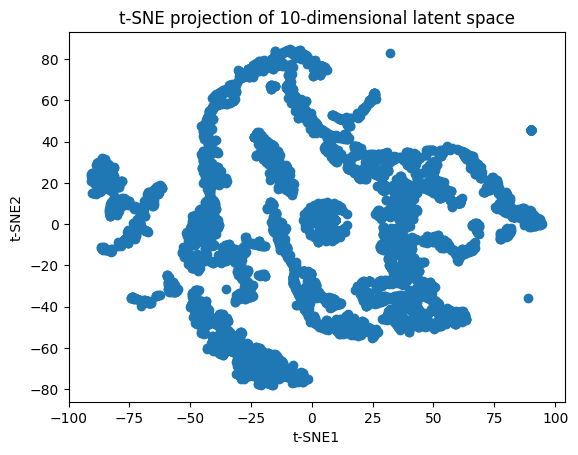

In [13]:
inputs = vae.get_layer('encoder_input').input
z_mean = vae.get_layer('z_mean').output

encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(train_sequences[:,:,1])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE projection of 10-dimensional latent space')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()


## Encode and decode some data points
#encoder = Model(inputs, z_mean)
#encoded_data = encoder.predict(train_sequences)

# Display some of the encoded data
#plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
#plt.xlabel("Dimension 1")
#plt.ylabel("Dimension 2")
#plt.title("Encoded Data")
#plt.show()


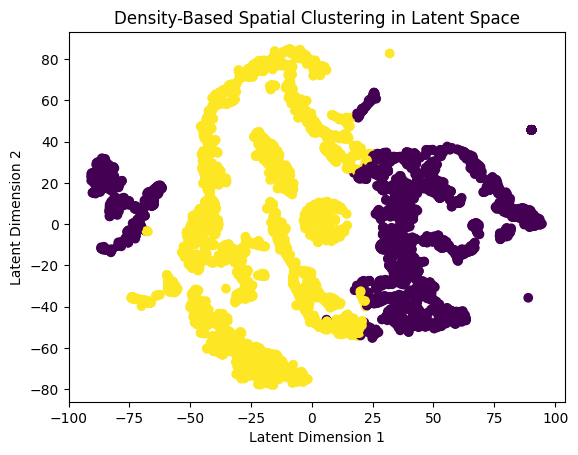

In [61]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


# Determine optimal number of clusters using the Elbow method
#wcss = []
#for i in range(1, 11):
#    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#    kmeans.fit(encoded_data)
#    wcss.append(kmeans.inertia_)

#plt.plot(range(1, 11), wcss)
#plt.title('Elbow Method')
#plt.xlabel('Number of clusters')
#plt.ylabel('WCSS')
#plt.show()

# Fit K-Means with optimal clusters
#np.random.seed(42)
#optimal_clusters = 4  # Example
#kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
#clusters = kmeans.fit_predict(encoded_data)


# Fit DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=1000)
clusters = dbscan.fit_predict(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Density-Based Spatial Clustering in Latent Space')
plt.show()



#from sklearn.mixture import GaussianMixture
# Fit GMM to the latent space
#gmm = GaussianMixture(n_components=4, random_state=0).fit(encoded_data)

# Assign cluster labels and get probabilities
#clusters = gmm.predict(encoded_data)
#probabilities = gmm.predict_proba(encoded_data)

# Visualize the clusters in the latent space (for 2D or 3D latent space)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.title('GMM Clustering in Latent Space')
#plt.show()

In [17]:
reconstructed_sequences = vae.predict(train_sequences[:,:,1])

222/222 [==============================] - 9s 24ms/step


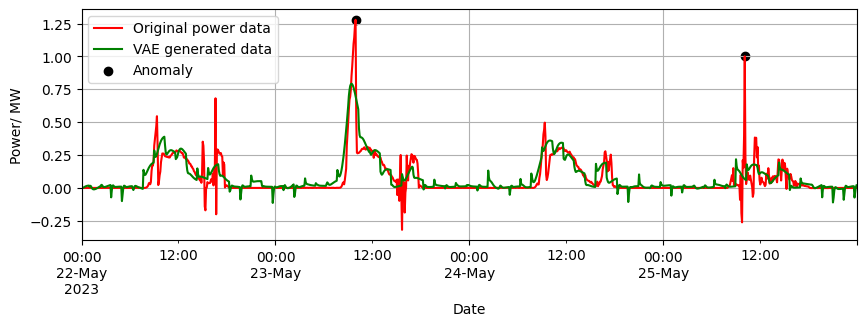

In [57]:
# 1. Reshape sequences back to original form
original_shape = (len(data), 2)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)
reconstruction_error = np.zeros(original_shape)


overlap = 8
num_sequences = (len(data) - timesteps) // timesteps + 1
step_size = timesteps - overlap
for i in range(num_sequences):
    start = i * step_size
    end = start + timesteps
    reconstructed_original_data[start:end] = train_sequences[i]
    reconstructed_vae_data[start:end] = reconstructed_sequences[i]


X_test_original = scaler.inverse_transform(reconstructed_original_data)
X_test_vae = scaler.inverse_transform(reconstructed_vae_data)

df_orginal = pd.DataFrame(data = X_test_original, index = train_data_date, columns = ['Power','Power_error'])
df_vae_output = pd.DataFrame(data = X_test_vae, index = train_data_date, columns = ['Power','Power_error'])
df_orginal['reconstruction_error'] = np.square(df_orginal['Power_error'] - df_vae_output['Power_error'])


# Threshold for anomaly detection
threshold = np.mean(df_orginal['reconstruction_error']) + 3 * np.std(df_orginal['reconstruction_error'])
df_orginal['anomaly'] =  df_orginal['reconstruction_error'] > threshold


# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-25'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]


df_orginal_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power data')
df_vae_output_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3),color =['Green'],label='VAE generated data')
plt.scatter(df_orginal_period.index[df_orginal_period['anomaly'] == 1], df_orginal_period['Power_error'][df_orginal_period['anomaly'] == 1], color='black', label='Anomaly')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()



In [58]:
array_b = np.zeros((7090, 24, 1))
reconstructed_sequences_temp = np.concatenate([reconstructed_sequences,array_b], axis=-1) 
reconstructed_sequences_temp[:,:,1] = train_sequences[:,:,1]

# Add cluster labels to the original sequences
clusters_temp = np.repeat(clusters[:, None, None], train_sequences.shape[1], axis=1)
original_sequences_with_clusters = np.concatenate([train_sequences, clusters_temp], axis=-1)
reconstructed_sequences_with_clusters = np.concatenate([reconstructed_sequences_temp, clusters_temp], axis=-1)


# Initialize an array to hold cluster IDs for the entire time series
cluster_ids = np.full(len(train_data), -1)




overlap = 8
num_sequences = (len(data) - timesteps) // timesteps + 1
step_size = timesteps - overlap
for i in range(num_sequences):
    start = i * step_size
    end = start + timesteps
    cluster_ids[start:end] = clusters[i]

'''
# Handle the overlapping indices by assigning the most frequent cluster ID
# Create a copy of cluster_ids to update with the most frequent cluster ID
updated_cluster_ids = cluster_ids.copy()
# Handle the overlapping indices by assigning the most frequent cluster ID
for i in range(len(cluster_ids) - timesteps + 1):
    window = cluster_ids[i:i + timesteps]
    unique, counts = np.unique(window[window != -1], return_counts=True)  # Ignore unassigned (-1) values
    if len(unique) > 0:  # Ensure there are assigned values in the window
        most_frequent_cluster = unique[np.argmax(counts)]
        updated_cluster_ids[i:i + timesteps] = most_frequent_cluster
'''

# Ensure the cluster_ids array has the same length as the original time series
cluster_ids = cluster_ids[:len(train_data)]

df_orginal['Clusters'] = cluster_ids


In [59]:
'''
# Preprocessing
power_ratio = df_orginal['Power_error'].values
scaler = MinMaxScaler(feature_range=(0, 1))
power_ratio_scaled = scaler.fit_transform(power_ratio.reshape(-1, 1))


# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(power_ratio_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


# Fit K-Means with optimal clusters
optimal_clusters = 4  # Example
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_orginal['data_clusters'] = kmeans.fit_predict(power_ratio_scaled)

from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan_labels = dbscan.fit_predict(power_ratio_scaled)

# Add DBSCAN labels to data
df_orginal['dbscan_label'] = dbscan_labels

print(df_orginal['dbscan_label'])

# Identify anomalies (label = -1 in DBSCAN)
#anomalies = data[data['dbscan_label'] == -1]
'''

'''
plt.scatter(data['timestamp'], power_ratio, c=data['cluster'], cmap='viridis')
plt.title('Power Ratio Clusters')
plt.xlabel('Time')
plt.ylabel('Power Ratio')
plt.show()


plt.scatter(data['timestamp'], power_ratio, c='blue', label='Normal')
plt.scatter(anomalies['timestamp'], anomalies['power_ratio'], c='red', label='Anomaly')
plt.title('Anomalies in Power Ratio')
plt.xlabel('Time')
plt.ylabel('Power Ratio')
plt.legend()
plt.show()
'''

"\nplt.scatter(data['timestamp'], power_ratio, c=data['cluster'], cmap='viridis')\nplt.title('Power Ratio Clusters')\nplt.xlabel('Time')\nplt.ylabel('Power Ratio')\nplt.show()\n\n\nplt.scatter(data['timestamp'], power_ratio, c='blue', label='Normal')\nplt.scatter(anomalies['timestamp'], anomalies['power_ratio'], c='red', label='Anomaly')\nplt.title('Anomalies in Power Ratio')\nplt.xlabel('Time')\nplt.ylabel('Power Ratio')\nplt.legend()\nplt.show()\n"

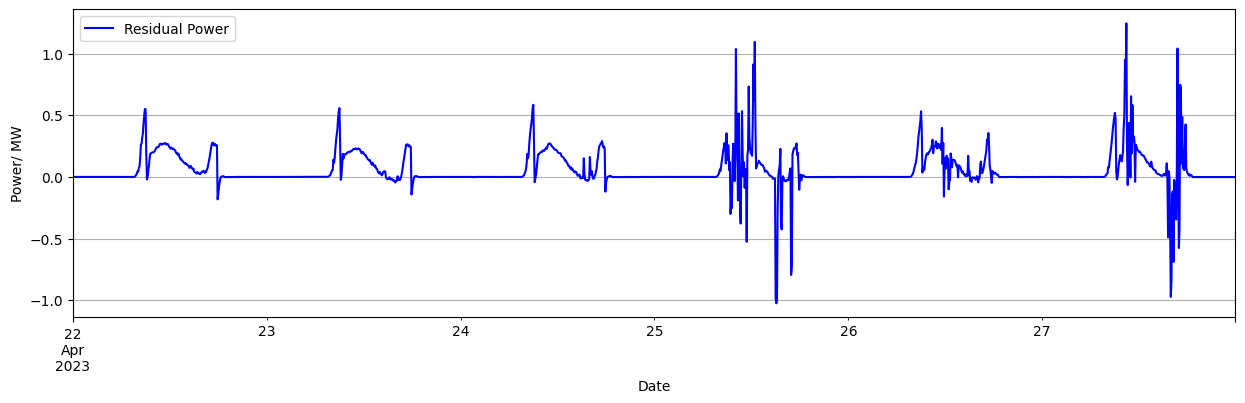

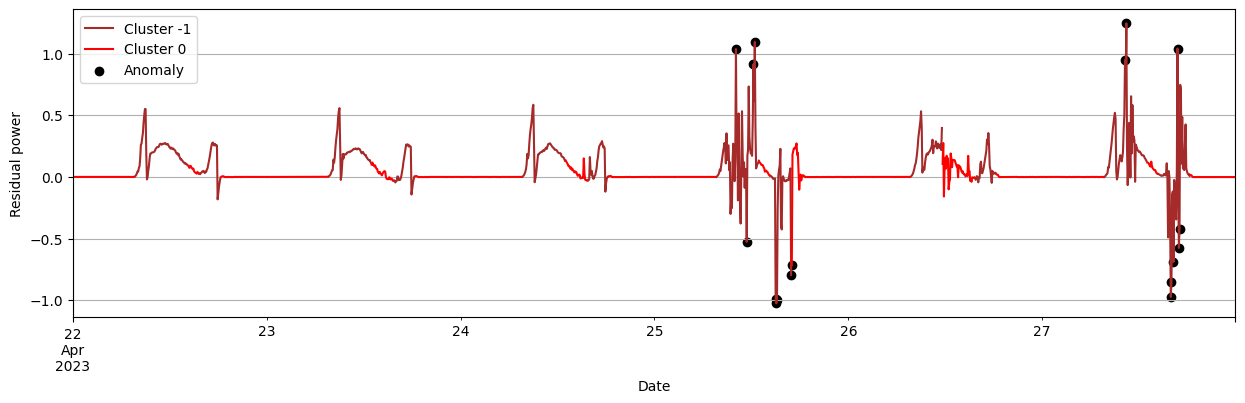

In [62]:
start_date = '2023-04-22'
end_date = '2023-04-27'

df_orginal['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Residual Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


# Check if clusters exist in the date range
for cluster in range(-1,4):
    cluster_data = df_orginal.query('Clusters == @cluster')[start_date:end_date]
    if not cluster_data.empty:
        cluster_data['Power_error'].resample('5min').mean().plot(
            figsize=(15, 4),
            color=['Red', 'Black', 'Green','Orange','Brown'][cluster],
            label=f'Cluster {cluster}'
        )
        
plt.scatter(df_orginal[start_date:end_date].index[df_orginal[start_date:end_date]['anomaly'] == 1], df_orginal[start_date:end_date]['Power_error'][df_orginal[start_date:end_date]['anomaly'] == 1], color='black', label='Anomaly')

# Add labels, grid, and legend
plt.ylabel('Residual power')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()